<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/10xFB/10xFB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Wed Jun  2 17:26:36 UTC 2021


In [2]:
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 227, done.
remote: Total 227 (delta 0), reused 0 (delta 0), pack-reused 227
Receiving objects: 100% (227/227), 187.14 MiB | 31.43 MiB/s, done.
Resolving deltas: 100% (70/70), done.
Checking out files: 100% (64/64), done.


In [3]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install --quiet \
  kb-python==0.26.0 \
  anndata==0.7.6 \

     |████████████████████████████████| 59.1MB 73kB/s 
     |████████████████████████████████| 133kB 30.4MB/s 
     |████████████████████████████████| 13.2MB 31.0MB/s 
     |████████████████████████████████| 10.3MB 23.1MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 112kB 47.2MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 1.2MB 29.1MB/s 


In [4]:
# extract everything
!ls /content/BMGP_2020/data/10xFB_5k_pbmc_v3/*/*.tar.gz |xargs -n1 tar -xf

In [5]:
!pip install --no-deps -i https://test.pypi.org/simple/ diffmx==0.0.2

Looking in indexes: https://test.pypi.org/simple/


# Imports

In [6]:
import anndata
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from diffmx import plot, compare
from diffmx.utils import nd, yex

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

colors = {
    "kb": "black",
    "cr": "red"
}

In [7]:
raw_kb = anndata.read_h5ad("/content/counts_unfiltered/adata.h5ad")

In [8]:
# cellranger outputs genes by cells, we output cells by genes
mtx_path = "/content/raw_feature_bc_matrix/matrix.mtx.gz"
mtx = mmread(mtx_path)
mmwrite("matrix_T.mtx", mtx.T)
!yes | gzip matrix_T.mtx

In [9]:
!gunzip /content/raw_feature_bc_matrix/features.tsv.gz
!cut -d$'\t' -f 1 /content/raw_feature_bc_matrix/features.tsv > features_1_col.tsv
!gzip features_1_col.tsv

In [10]:
raw_cr = import_matrix_as_anndata("./matrix_T.mtx.gz", "/content/raw_feature_bc_matrix/barcodes.tsv.gz", "features_1_col.tsv.gz", t2g_path="/content/BMGP_2020/references/10xFB_5k_pbmc_v3/kite/f2b.txt")
raw_cr.obs.index = raw_cr.obs.index.str.slice(0, 16).values

In [11]:
df = pd.read_csv("/content/filtered_feature_bc_matrix/barcodes.tsv.gz", names=["bcs"], header=None)
df["bcs"] = df["bcs"].str.slice(0, 16).values

In [12]:
common = np.intersect1d(np.intersect1d(raw_cr.obs.index.values, raw_kb.obs.index.values), df.bcs.values)

In [13]:
kb = raw_kb[raw_kb.obs.index.isin(common)]
cr = raw_cr[raw_cr.obs.index.isin(common)]

In [14]:
print(kb)
print(cr)

View of AnnData object with n_obs × n_vars = 5266 × 32
    var: 'feature_name'
View of AnnData object with n_obs × n_vars = 5266 × 32
    var: 'gene_name'


# Visualizations

## Knee

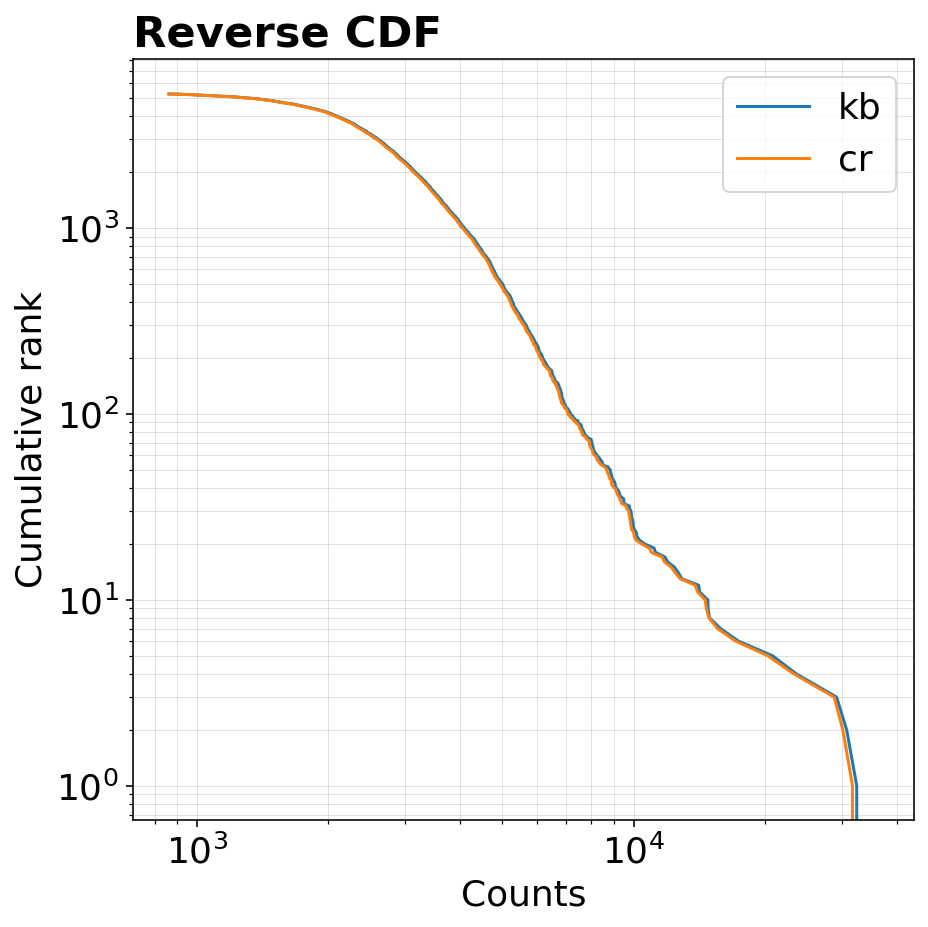

In [17]:
fig, ax = plt.subplots(figsize=(7,7))

x0,x1 = compare.rev_cdf(kb.X, cr.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=["kb", "cr"], colors=[colors["kb"], colors["cr"]])

fig.show()

## pseudobulk

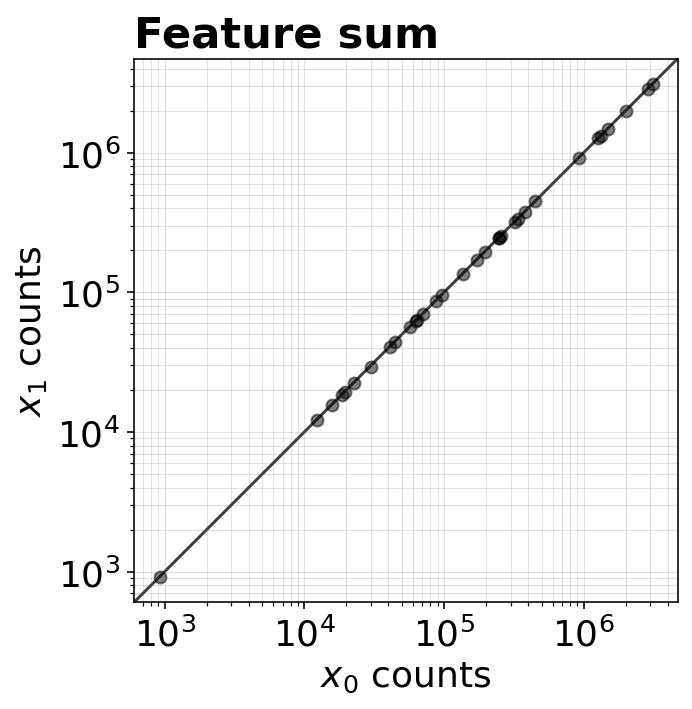

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
x0, x1 = compare.cmp_sum(kb.X, cr.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5)
fig.show()

In [24]:
x0, corr = compare.features_correlated(kb.X, cr.X)

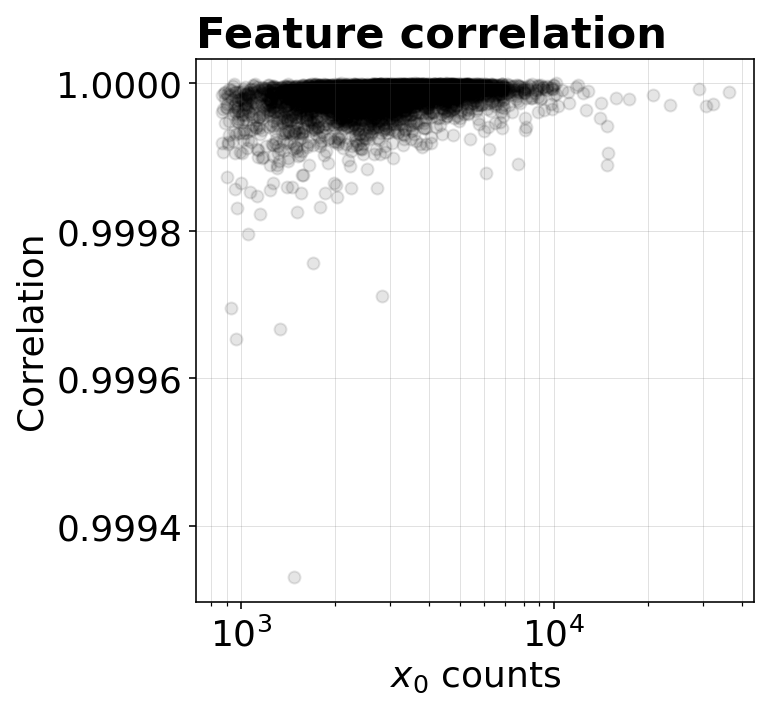

In [26]:
fig, ax = plt.subplots(figsize=(5,5))
plot.features_correlated(x0, corr, ax=ax)
fig.show()

### $l_1$ dist

In [27]:
XX, XY = compare.l1_distance(kb.X, cr.X)
YY, YX = compare.l1_distance(cr.X, kb.X)

In [32]:
colors

{'cr': 'red', 'kb': 'black'}

In [31]:
list(colors.values())

['black', 'red']

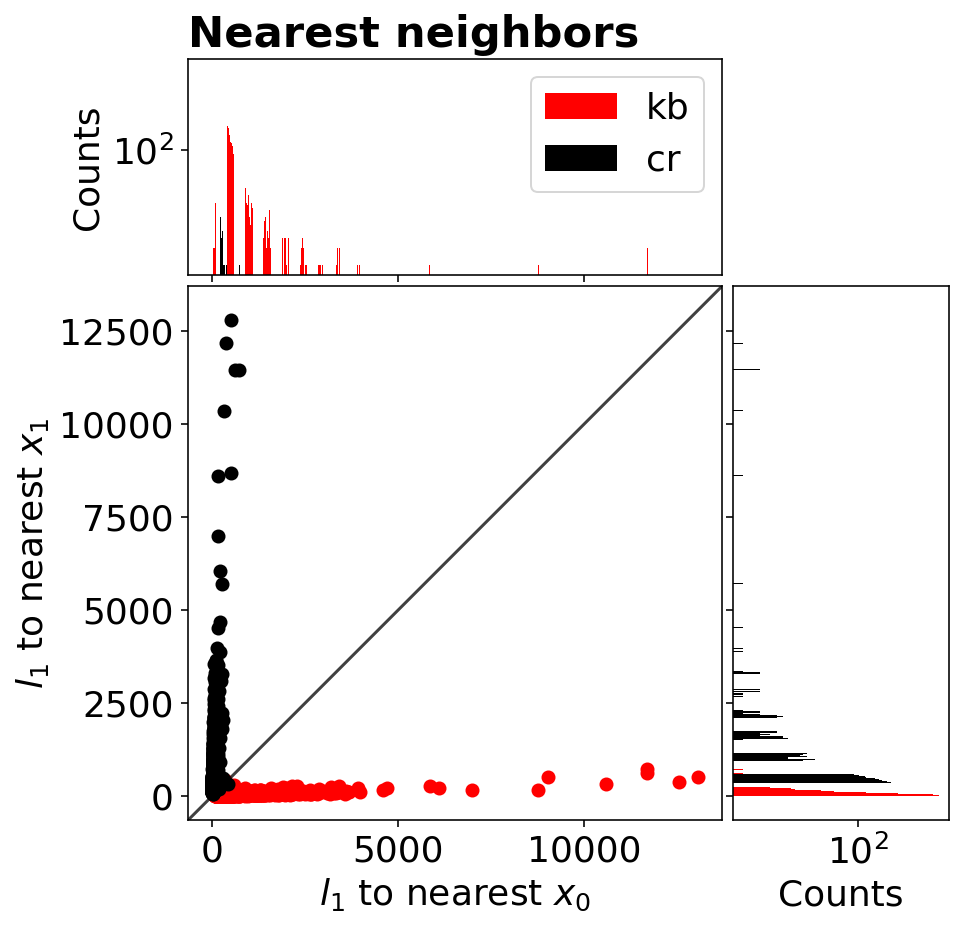

In [33]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_nearest_neighbor((XX, YY), (XY, YX), ax=ax, labels=["kb", "cr"], colors=list(colors.values())[::-1])

fig.show()

In [40]:
cnts = compare.sum_features(kb.X, axis=1)

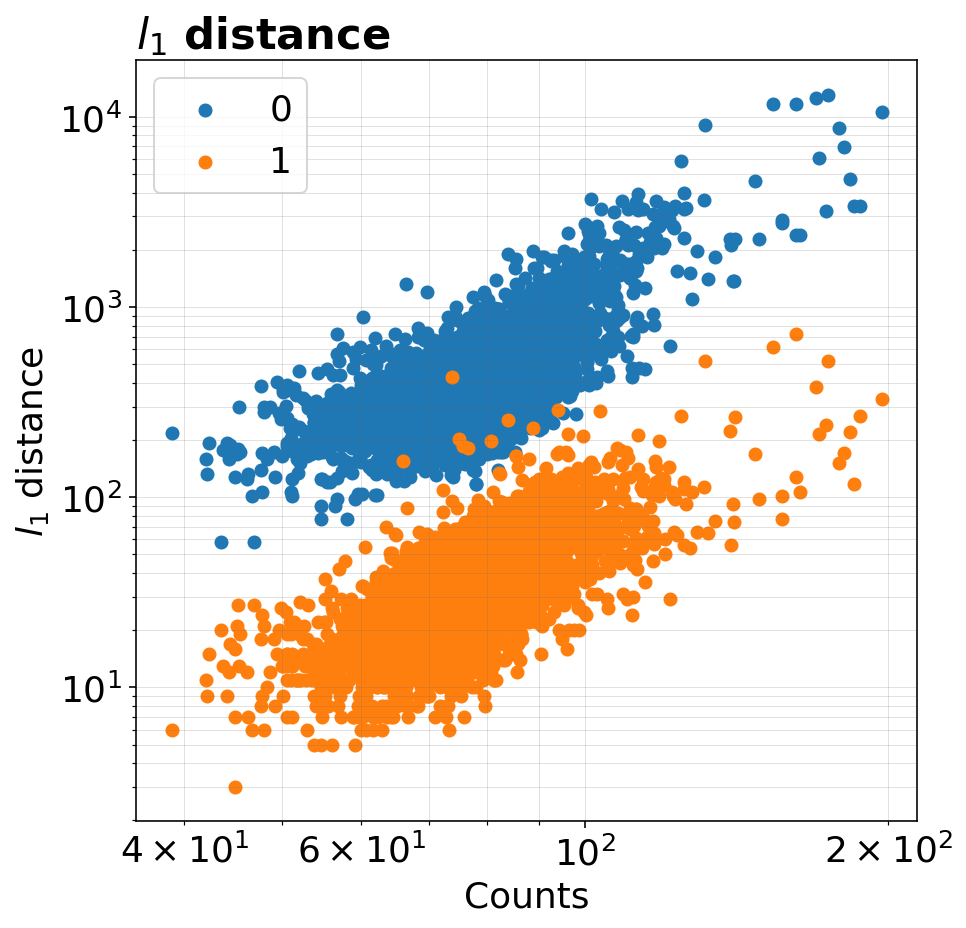

In [43]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_counts((cnts, XX), (cnts, XY), ax=ax, colors=list(colors.values())[::-1])

fig.show()

----------------------------------------